In [1]:
%matplotlib inline

In [2]:
import itertools
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_bids

In [3]:
ROOT = Path("../data/MASC-MEG")

In [42]:
phoneme_info = pd.read_csv(ROOT / "phoneme_info.csv")

In [4]:
class Parameters(dict):

    def __getattr__(self, attr):
        try:
            if isinstance(self[attr], dict):
                return Parameters(**self[attr])
            return self[attr]
        except KeyError:
            raise AttributeError(attr)
        
    def __getitem__(self, item):
        if item in self:
            if isinstance(self.get(item), dict):
                return Parameters(**self.get(item))
            return self.get(item)
        else:
            raise KeyError(item)

    def __repr__(self):
        return "Parameters " + super(Parameters, self).__repr__()

    def __str__(self):
        return "Parameters " + super(Parameters, self).__str__()

In [5]:
P = Parameters(
    bandpass=dict(high=30.0, low=0.5),
    scaler="RobustScaler",
    scaler_params=dict(q1=25.0, q3=75.0),
    seed=42,
    epochs=dict(decim=10, tmin=-0.5, tmax=3.0, baseline=(-0.5, 0.0)),
    decimation=10,
    sampling_rate=1000,
    )

In [26]:
def get_epochs(subject, level="all"):
    all_w_epochs, all_ph_epochs = list(), list()
    for session, task in itertools.product(range(2), range(2)):
        print(f"Loading: sub{subject}-sess{session}-task{task}")

        bids_path = mne_bids.BIDSPath(
            subject=subject, 
            session=str(session), 
            task=str(task),
            datatype="meg",
            root=ROOT
        )

        try:
            raw = mne_bids.read_raw_bids(bids_path)
        except FileNotFoundError:
            print(f"Not found: sub{subject}-sess{session}-task{task}")
            continue

        raw = raw.pick_types(
            meg=True, misc=False, eeg=False, eog=False, ecg=False
        )

        raw.load_data().filter(
            P.bandpass.low, 
            P.bandpass.high, 
            n_jobs=1
        )

        annotations = preprocess_annotations(raw)

        w_epochs = ph_epochs = None
        if level in ["word", "all"]:
            words = annotations.query("kind=='word'")
            w_epochs = segment(raw, words)
            w_epochs.metadata["half"] = np.round(
                np.linspace(0, 1.0, len(w_epochs))
            ).astype(int)
            w_epochs.metadata["task"] = task
            w_epochs.metadata["session"] = session

            all_w_epochs.append(w_epochs)

        if level in ["phoneme", "all"]:
            phonemes = annotations.query("kind=='phoneme'")
            ph_epochs = segment(raw, phonemes)
            ph_epochs.metadata["half"] = np.round(
                np.linspace(0, 1.0, len(ph_epochs))
            ).astype(int)
            ph_epochs.metadata["task"] = task
            ph_epochs.metadata["session"] = session

            all_ph_epochs.append(ph_epochs)
    
    w_epochs = None
    if len(all_w_epochs) > 0:
        w_epochs = concatenate(all_w_epochs)
        
    ph_epochs = None
    if len(all_ph_epochs) > 0:
        ph_epochs = concatenate(all_ph_epochs)

    return w_epochs, ph_epochs, annotations

def concatenate(all_epochs):
    epochs = mne.concatenate_epochs(all_epochs)
    m = epochs.metadata
    label = (
        "t"
        + m.task.astype(str)
        + "_s"
        + m.session.astype(str)
        + "_h"
        + m.half.astype(str)
    )
    epochs.metadata["label"] = label

    return epochs
    
def preprocess_annotations(raw):
    df_raw = raw.annotations.to_data_frame()
    df_raw["onset"] = raw.annotations.onset
    df_desc = pd.DataFrame(df_raw.description.apply(eval).to_list())
    df = pd.concat([df_raw.drop("description", axis=1), df_desc], axis=1)
    
    df[["index", "subject"]] = df[["index", "subject"]].fillna(method="ffill")
    
    df_ = df.copy().query("kind != 'sound'")
    
    df_["word"] = df_["word"].shift(-1)
    df_filled = df_["word"].fillna(method="ffill")
    
    df.loc[df["kind"] != "sound", "word"] = df_filled
    
    return df
    
def segment(raw, meta):
    events = np.c_[
        meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
    ].astype(int)

    epochs = mne.Epochs(
        raw,
        events,
        tmin=P.epochs.tmin,
        tmax=P.epochs.tmax,
        decim=P.epochs.decim,
        baseline=P.epochs.baseline,
        metadata=meta,
        preload=True,
        event_repeated="drop",
    )
    
    return epochs

In [27]:
_, ph_epochs, df = get_epochs(subject="12", level="phoneme")

Loading: sub12-sess0-task0
Extracting SQD Parameters from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_events.tsv.
Reading channel info from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading 0 ... 371999  =      0.000 ...   371.999 secs...


/tmp/ipykernel_27259/1038733399.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 sec)

Adding metadata with 19 columns
2462 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2462 events and 3501 original time points (prior to decimation) ...
0 bad epochs dropped
Loading: sub12-sess0-task1
Extracting SQD Parameters from ../data/MASC-MEG/sub-12/ses-0/meg/sub-12_ses-0_task-1_meg.con...
Creating Raw.info structure...
Setting channel info structu

/tmp/ipykernel_27259/1038733399.py:15: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 sec)

Adding metadata with 19 columns
5113 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 5113 events and 3501 original time points (prior to decimation) ...
0 bad epochs dropped
Loading: sub12-sess1-task0
Not found: sub12-sess1-task0
Loading: sub12-sess1-task1
Not found: sub12-sess1-task1


/tmp/ipykernel_27259/1038733399.py:66: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(all_epochs)


Adding metadata with 22 columns
7575 matching events found
Applying baseline correction (mode: mean)


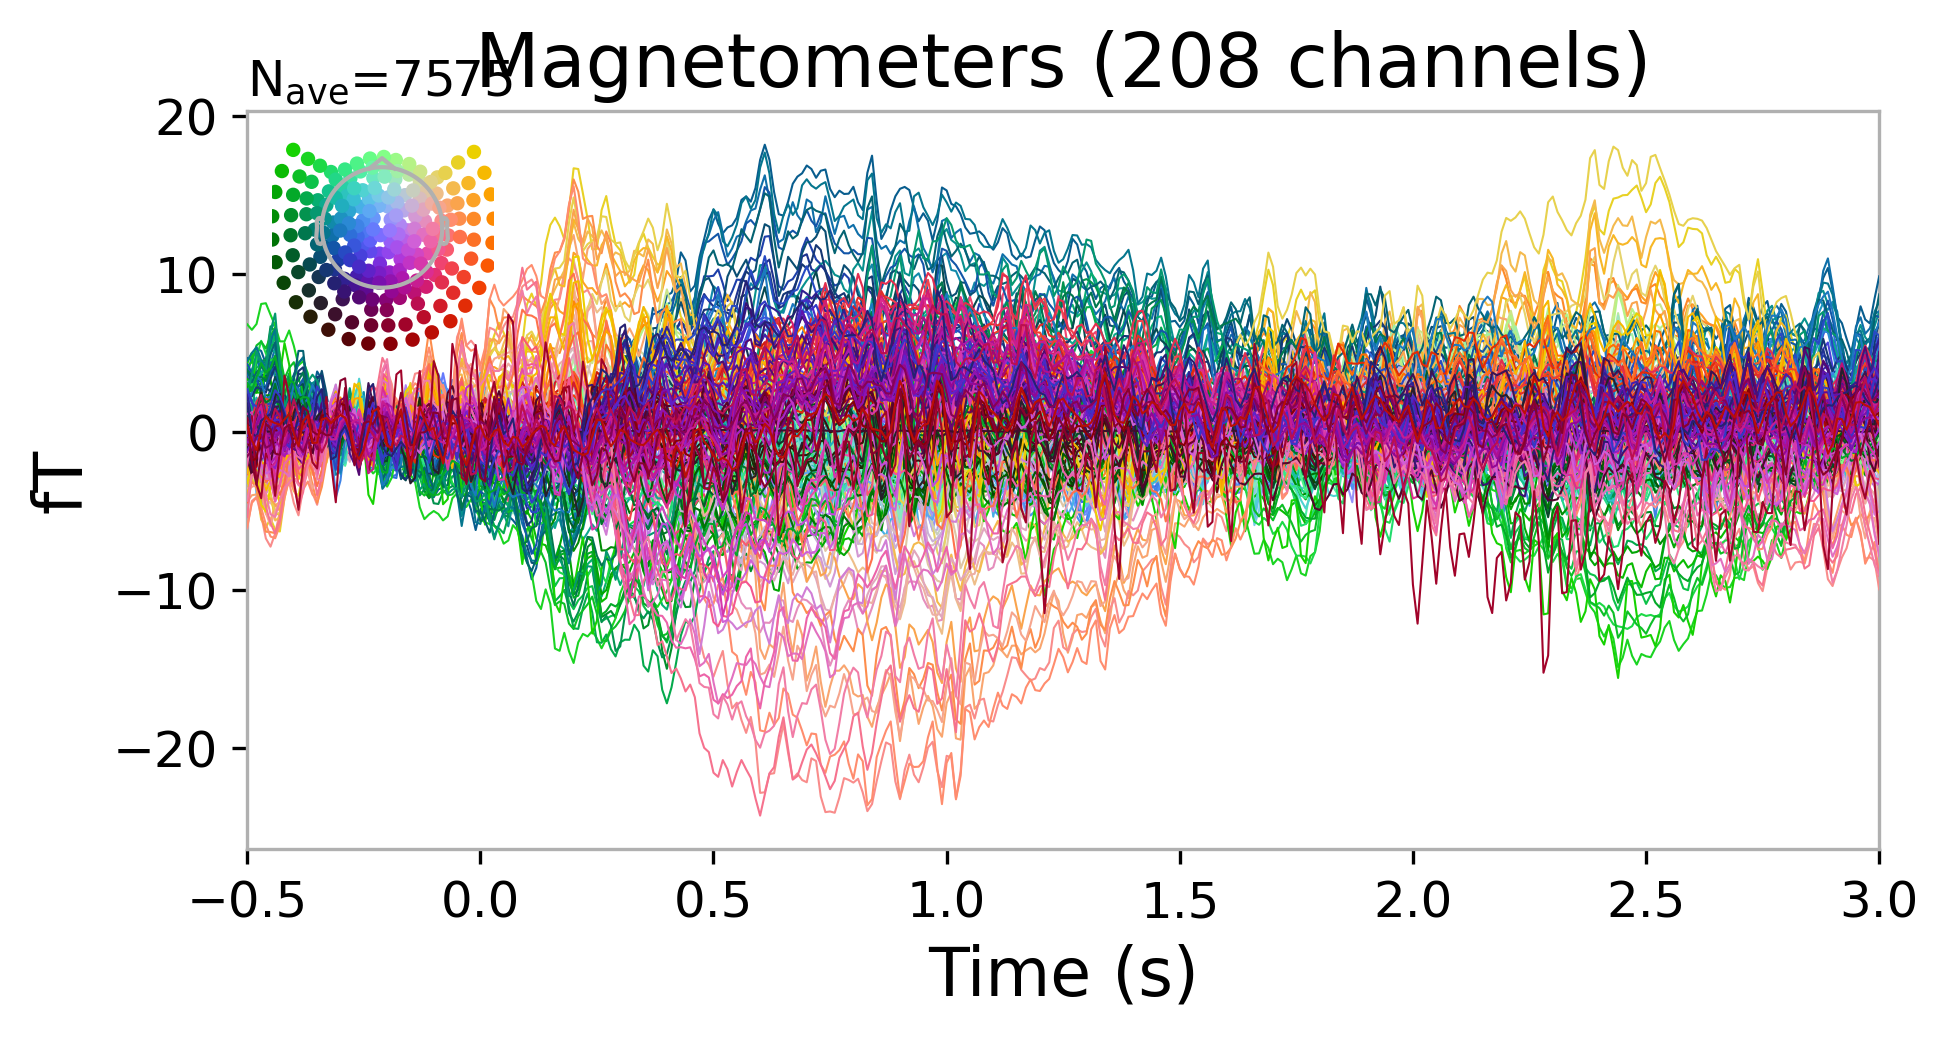

In [13]:
ph_epochs.average().plot()
plt.show()

In [14]:
X = ph_epochs.get_data()[:, :208, :]

In [15]:
X.shape

(7575, 208, 351)

In [30]:
ph_epochs.info["sfreq"]

100.0

In [ ]:
def tile_annotations(epochs, X, phoneme_info):
    
    annots = epochs.metadata
    sfreq = epochs.info["sfreq"]
    n_samples, _, n_timepts = epochs[i].get_data().shape
    
    y = np.zeros((n_samples, 1, n_timepts))
    for i in range(len(word_epochs)):
        meta = word_epochs[i].metadata
        start_onset = float(meta.onset.values[0])
        in_epoch_words = words[(words["onset"] >= start_onset) & (words["onset"] <= (start_onset+3.0))]
        in_epoch_phons = phonemes[(phonemes["onset"] >= start_onset) & (phonemes["onset"] <= (start_onset+3.0))]

        n_timepts = word_epochs[i].get_data().shape[2]

        words_data = ["SIL"] *
        phons_data = 

In [ ]:
phonemes = df.query("kind=='phoneme'")
words = df.query("kind=='word'")
y_phonemes = []
y_words = []
for i in range(len(word_epochs)):
    meta = word_epochs[i].metadata
    start_onset = float(meta.onset.values[0])
    in_epoch_words = words[(words["onset"] >= start_onset) & (words["onset"] <= (start_onset+3.0))]
    in_epoch_phons = phonemes[(phonemes["onset"] >= start_onset) & (phonemes["onset"] <= (start_onset+3.0))]
    
    n_timepts = word_epochs[i].get_data().shape[2]
    
    words_data = ["SIL"] *
    phons_data = 

In [ ]:
type(float(words.onset.values[0]))

In [ ]:
words.reset_index(drop=True).loc[9, :]

In [ ]:
X.shape  # (n_epochs, n_channels, n_timesteps)

In [ ]:
evoked_word = word_epochs.average()
evoked_word.plot(spatial_colors=True)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

n_train, n_channels, time_length = X_train.shape
n_test = X_test.shape[0]

robust_scaler = RobustScaler()  # quantile_range=(5.0, 95.0))

X_train = robust_scaler.fit_transform(X_train.reshape(-1, n_channels))
X_test = robust_scaler.transform(X_test.reshape(-1, n_channels))

th = 20
X_train = np.clip(X_train, -th, th).reshape(n_train, time_length, n_channels)
X_test = np.clip(X_test, -th, th).reshape(n_test, time_length, n_channels)

In [ ]:
plt.plot(X_train[0])
plt.show()

In [ ]:
plt.plot(X_train.mean(axis=0))
plt.show()

In [ ]:
plt.hist(X_train.flatten(), bins=100)
plt.show()

## Code from https://github.com/kingjr/meg-masc

In [ ]:
# ALREADY DONE ABOVE
# meta = df
# meta = list()
# for annot in raw.annotations:
#     d = eval(annot.pop("description"))
#     for k, v in annot.items():
#         assert k not in d.keys()
#         d[k] = v
#     meta.append(d)
# meta = pd.DataFrame(meta)
# meta["intercept"] = 1.0

In [ ]:
# compute voicing
assert len(df_ph)
for ph, d in df_ph.groupby("phoneme"):
    ph = ph.split("_")[0]
    match = ph_info.query("phoneme==@ph")
    assert len(match) == 1
    df.loc[d.index, "voiced"] = match.iloc[0].phonation == "v"

In [ ]:
df[["kind", "onset", "phoneme", "voiced"]].head(10)

In [ ]:
words = df.query('kind=="word"').copy()
words

In [ ]:
df.loc[words.index + 1]

In [ ]:
X = raw.get_data()

In [ ]:
sr = 100
onset_w = 15.473
next_onset = 15.783
onset = 15.553
start, end = round(sr * (onset - 0.2)), round(sr * (onset + 0.6))
t = np.arange(start, end)
n_ch = 20

x_dec = X[:, ::10]

th = np.percentile(np.abs(x_dec), 95)
x_th = np.clip(x_dec, -th, th)

baseline = x_th[:, : start + 200].mean(axis=1)
x_corr = x_th[:, start:end] - np.repeat(baseline.reshape(-1, 1), end - start, axis=1)

plt.plot(t, x_corr.T, c="gray", alpha=0.25)
plt.axvline(round(onset * sr))
plt.axvline(round(onset_w * sr), color="r")
plt.axvline(round(next_onset * sr), color="r")
plt.show()

In [ ]:
# why is index shifted by +1 ??

# compute word frquency and merge w/ phoneme
meta["is_word"] = False
words = meta.query('kind=="word"').copy()
assert len(words) > 10
# assert np.all(meta.loc[words.index + 1, "kind"] == "phoneme")
meta.loc[words.index + 1, "is_word"] = True
wfreq = lambda x: zipf_frequency(x, "en")  # noqa
meta.loc[words.index + 1, "wordfreq"] = words.word.apply(wfreq).values

In [ ]:
meta[["kind", "onset", "duration", "phoneme", "word", "is_word", "wordfreq"]]

In [ ]:
events = np.c_[meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))].astype(int)

In [ ]:
meta.onset * raw.info["sfreq"]

In [ ]:
events

In [ ]:
# preproc annotations
from wordfreq import zipf_frequency

meta = list()
for annot in raw.annotations:
    d = eval(annot.pop("description"))
    for k, v in annot.items():
        assert k not in d.keys()
        d[k] = v
    meta.append(d)
meta = pd.DataFrame(meta)
meta["intercept"] = 1.0

# compute voicing
phonemes = meta.query('kind=="phoneme"')
assert len(phonemes)
for ph, d in phonemes.groupby("phoneme"):
    ph = ph.split("_")[0]
    match = ph_info.query("phoneme==@ph")
    assert len(match) == 1
    meta.loc[d.index, "voiced"] = match.iloc[0].phonation == "v"

# compute word frquency and merge w/ phoneme
meta["is_word"] = False
words = meta.query('kind=="word"').copy()
assert len(words) > 10
# assert np.all(meta.loc[words.index + 1, "kind"] == "phoneme")
meta.loc[words.index + 1, "is_word"] = True
wfreq = lambda x: zipf_frequency(x, "en")  # noqa
meta.loc[words.index + 1, "wordfreq"] = words.word.apply(wfreq).values

meta = meta.query('kind=="phoneme"')
assert len(meta.wordfreq.unique()) > 2

# segment
events = np.c_[meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))].astype(int)

epochs = mne.Epochs(
    raw,
    events,
    tmin=-0.2,
    tmax=3,
    decim=10,
    baseline=(-0.2, 0.0),
    metadata=meta,
    preload=True,
    event_repeated="drop",
)

# threshold
th = np.percentile(np.abs(epochs._data), 95)
epochs._data[:] = np.clip(epochs._data, -th, th)
epochs.apply_baseline()
th = np.percentile(np.abs(epochs._data), 95)
epochs._data[:] = np.clip(epochs._data, -th, th)
epochs.apply_baseline()